In [29]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from pyod.models.iforest import IForest
from pyod.models.dif import DIF
from pyod.models.loda import LODA
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

## Ex1
### 1.1

In [2]:
X, y = make_blobs(n_samples=500, centers=1, cluster_std=1.0, random_state=42)

### 1.2

In [3]:
num_vectors = 5
projection_vectors = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], num_vectors)
projection_vectors /= np.linalg.norm(projection_vectors, axis=1)[:, np.newaxis]  

projected_values = [X @ vector for vector in projection_vectors]

data_range = (-10, 10)
num_bins = 20

probabilities = []

for values in projected_values:
    hist, bin_edges = np.histogram(values, bins=num_bins, range=data_range, density=True)

    hist += 1e-10
    bin_width = bin_edges[1] - bin_edges[0]
    prob = hist * bin_width  
    probabilities.append(prob)

anomaly_scores = np.mean(probabilities, axis=0)

print("Projection Vectors:\n", projection_vectors)
print("Anomaly Scores:\n", anomaly_scores)


Projection Vectors:
 [[ 0.89785389 -0.44029354]
 [-0.99922442 -0.03937706]
 [-0.02142017 -0.99977056]
 [-0.40496702 -0.91433129]
 [-0.4159419   0.90939119]]
Anomaly Scores:
 [8.87010678e-02 1.24108100e-01 1.44028433e-01 1.41922319e-01
 7.84368738e-02 1.92032065e-02 3.60000010e-03 1.00000000e-10
 1.00000000e-10 4.00000010e-03 1.96000001e-02 6.28000001e-02
 7.68000001e-02 3.16000001e-02 4.80000010e-03 4.00000100e-04
 2.11081804e-03 2.42744064e-02 7.81002640e-02 9.55145120e-02]


### 1.3 + 1.4

In [4]:
test_data = np.random.uniform(-3, 3, (500, 2))

def calculate_anomaly_scores(test_data, projection_vectors, num_bins, data_range):
    projected_test_values = [test_data @ vector for vector in projection_vectors]
    test_probabilities = []

    for values in projected_test_values:
        hist, bin_edges = np.histogram(values, bins=num_bins, range=data_range, density=True)
    
        bin_indices = np.digitize(values, bin_edges) - 1
        bin_indices = np.clip(bin_indices, 0, len(hist) - 1)  
        prob = hist[bin_indices]
        test_probabilities.append(prob)

    test_anomaly_scores = np.mean(test_probabilities, axis=0)
    return test_anomaly_scores


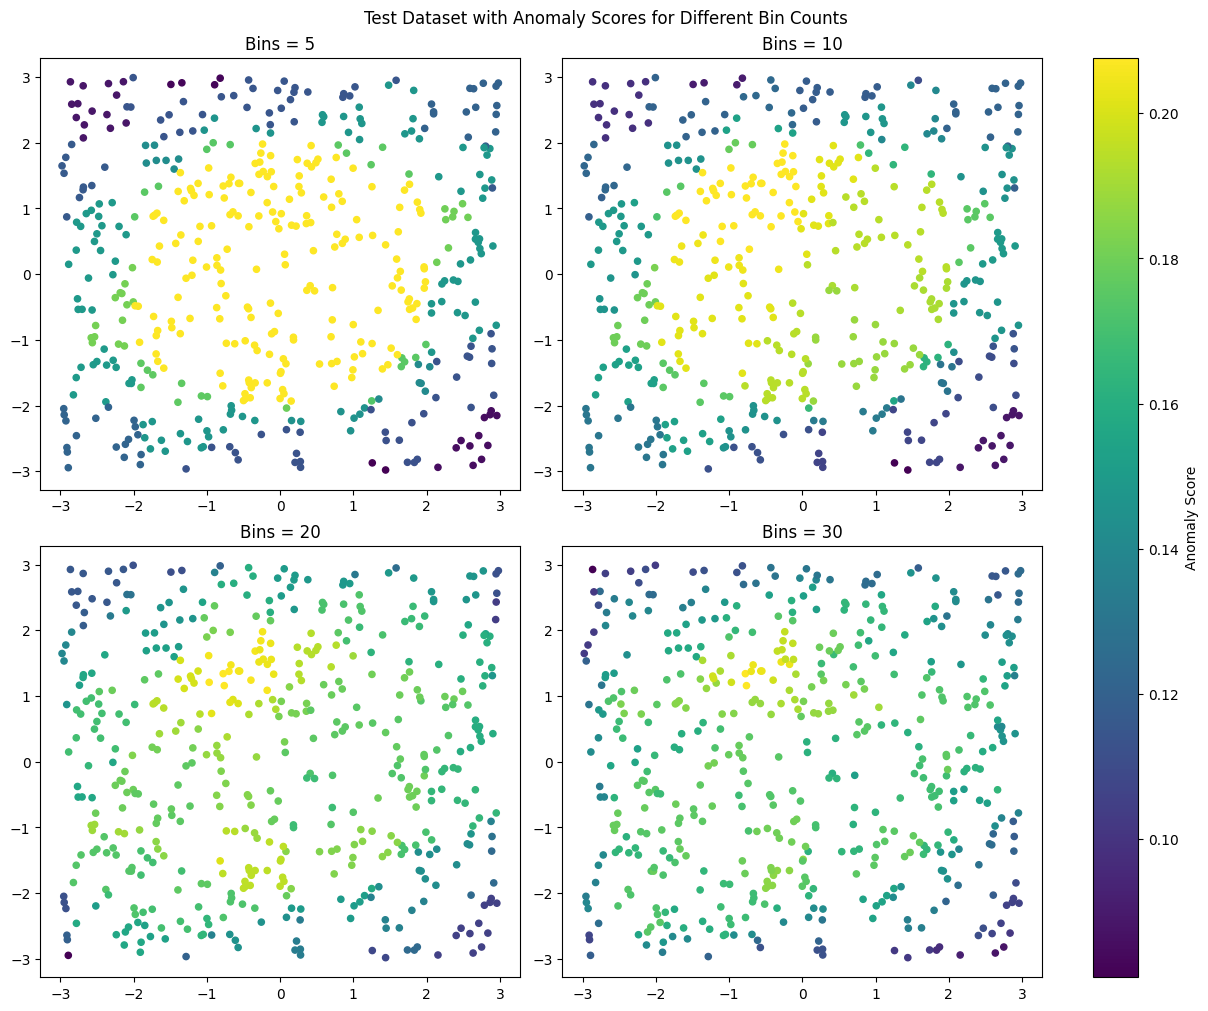

In [5]:
bin_settings = [5, 10, 20, 30]  

fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

axs = axs.flatten()

for ax, num_bins in zip(axs, bin_settings):
    test_anomaly_scores = calculate_anomaly_scores(test_data, projection_vectors, num_bins, data_range)
    scatter = ax.scatter(test_data[:, 0], test_data[:, 1], c=test_anomaly_scores, cmap='viridis', s=20)
    ax.set_title(f"Bins = {num_bins}")

fig.colorbar(scatter, ax=axs, orientation="vertical", label="Anomaly Score")
plt.suptitle("Test Dataset with Anomaly Scores for Different Bin Counts")
plt.show()

## Ex2

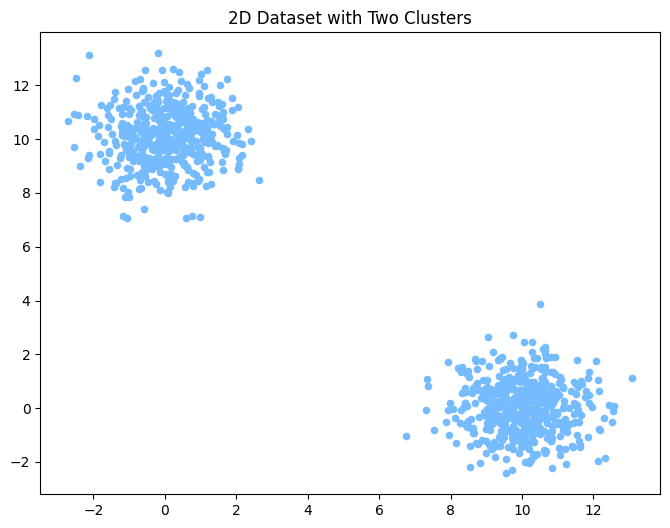

In [23]:
n_samples = 500
cluster_centers = [(10, 0), (0, 10)]

X2, y2 = make_blobs(n_samples=[n_samples, n_samples], centers=cluster_centers, cluster_std=1.0, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X2[:, 0], X2[:, 1], c='xkcd:sky blue', s=20)
plt.title("2D Dataset with Two Clusters")
plt.show()

In [13]:
contamination_rate = 0.02

iforest = IForest(contamination=contamination_rate, random_state=42)
iforest.fit(X2)

test_date = np.random.uniform(-10, 20, (1000, 2))

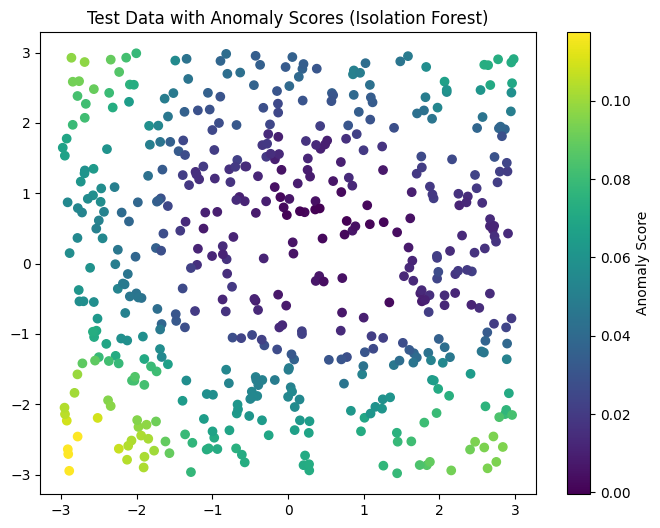

In [14]:
iforest_scores = iforest.decision_function(test_data)
test_anomaly_labels = iforest.predict(test_data)

plt.figure(figsize=(8,6))
scatter = plt.scatter(test_data[:, 0], test_data[:, 1], c=iforest_scores, cmap='viridis')
plt.colorbar(scatter, label="Anomaly Score")
plt.title("Test Data with Anomaly Scores (Isolation Forest)")
plt.show()

In [15]:
dif = DIF(contamination=contamination_rate, random_state=42)
dif.fit(X2)
dif_scores = dif.decision_function(test_data)

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warn

In [16]:
loda = LODA(contamination=contamination_rate)
loda.fit(X2)
loda_scores = loda.decision_function(test_data)


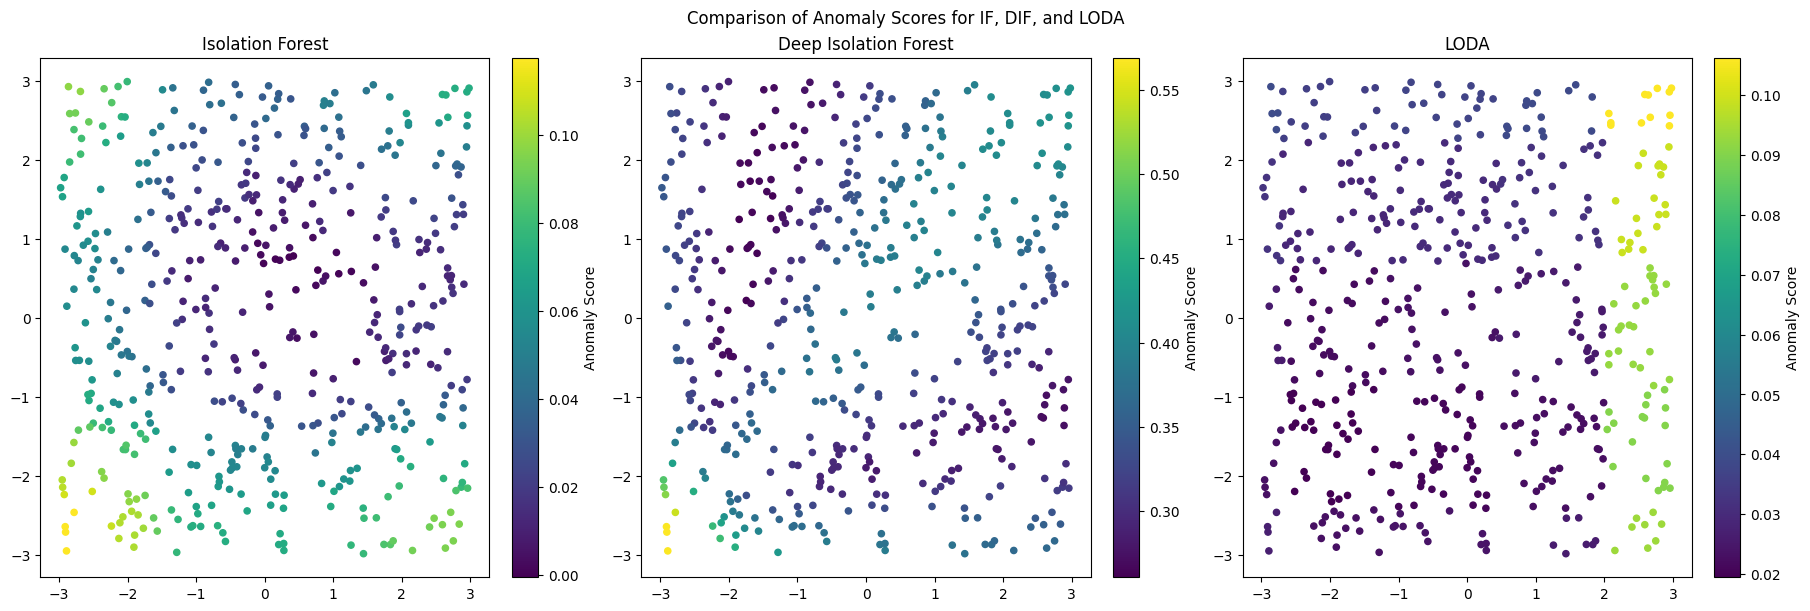

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

scatter = axs[0].scatter(test_data[:, 0], test_data[:, 1], c=iforest_scores, cmap='viridis', s=20)
axs[0].set_title("Isolation Forest")
fig.colorbar(scatter, ax=axs[0], label="Anomaly Score")

scatter = axs[1].scatter(test_data[:, 0], test_data[:, 1], c=dif_scores, cmap='viridis', s=20)
axs[1].set_title("Deep Isolation Forest")
fig.colorbar(scatter, ax=axs[1], label="Anomaly Score")

scatter = axs[2].scatter(test_data[:, 0], test_data[:, 1], c=loda_scores, cmap='viridis', s=20)
axs[2].set_title("LODA")
fig.colorbar(scatter, ax=axs[2], label="Anomaly Score")

plt.suptitle("Comparison of Anomaly Scores for IF, DIF, and LODA")
plt.show()

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warn

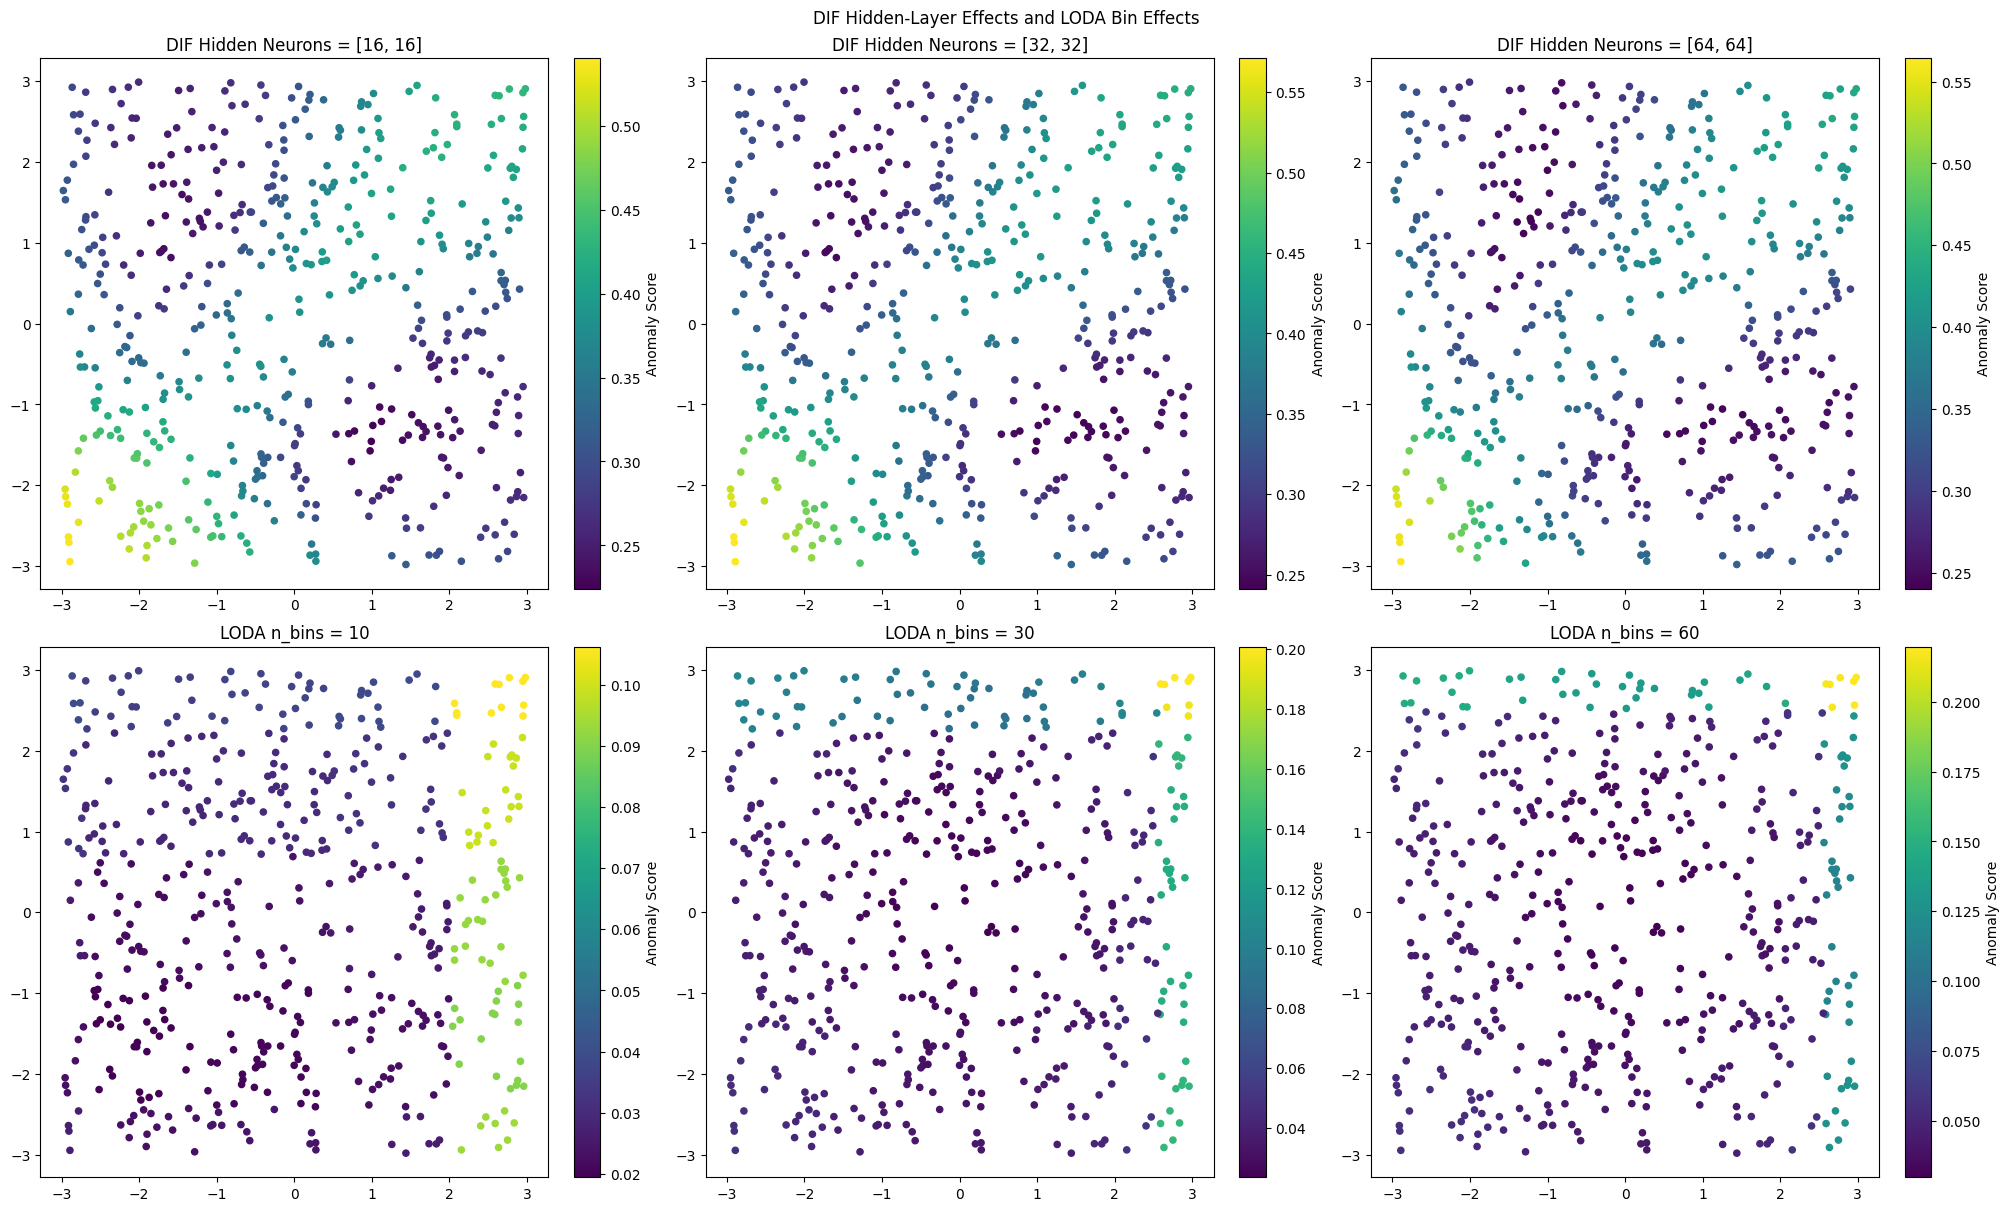

In [18]:
hidden_configs = [[16, 16], [32, 32], [64, 64]]

bin_configs = [10, 30, 60]

fig, axs = plt.subplots(2, 3, figsize=(20, 12), constrained_layout=True)

for i, neurons in enumerate(hidden_configs):
    dif_var = DIF(contamination=contamination_rate,
                  hidden_neurons=neurons, random_state=42)
    dif_var.fit(X2)

    dif_scores_var = dif_var.decision_function(test_data)

    scatter = axs[0, i].scatter(test_data[:, 0], test_data[:, 1],
                                c=dif_scores_var, cmap='viridis', s=20)
    axs[0, i].set_title(f"DIF Hidden Neurons = {neurons}")
    fig.colorbar(scatter, ax=axs[0, i], label="Anomaly Score")


for j, nbins in enumerate(bin_configs):
    loda_var = LODA(contamination=contamination_rate, n_bins=nbins)
    loda_var.fit(X2)

    loda_scores_var = loda_var.decision_function(test_data)

    scatter = axs[1, j].scatter(test_data[:, 0], test_data[:, 1],
                                c=loda_scores_var, cmap='viridis', s=20)
    axs[1, j].set_title(f"LODA n_bins = {nbins}")
    fig.colorbar(scatter, ax=axs[1, j], label="Anomaly Score")

plt.suptitle("DIF Hidden-Layer Effects and LODA Bin Effects")
plt.show()

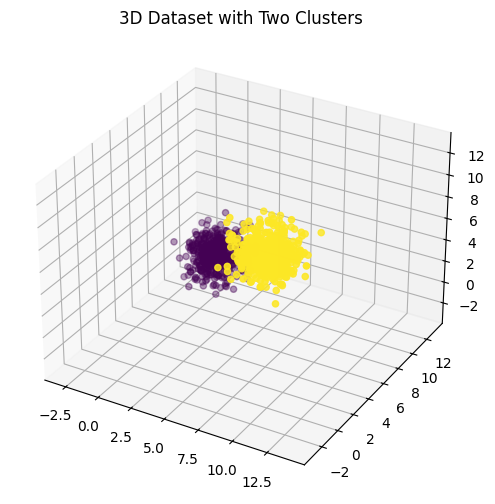

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warn

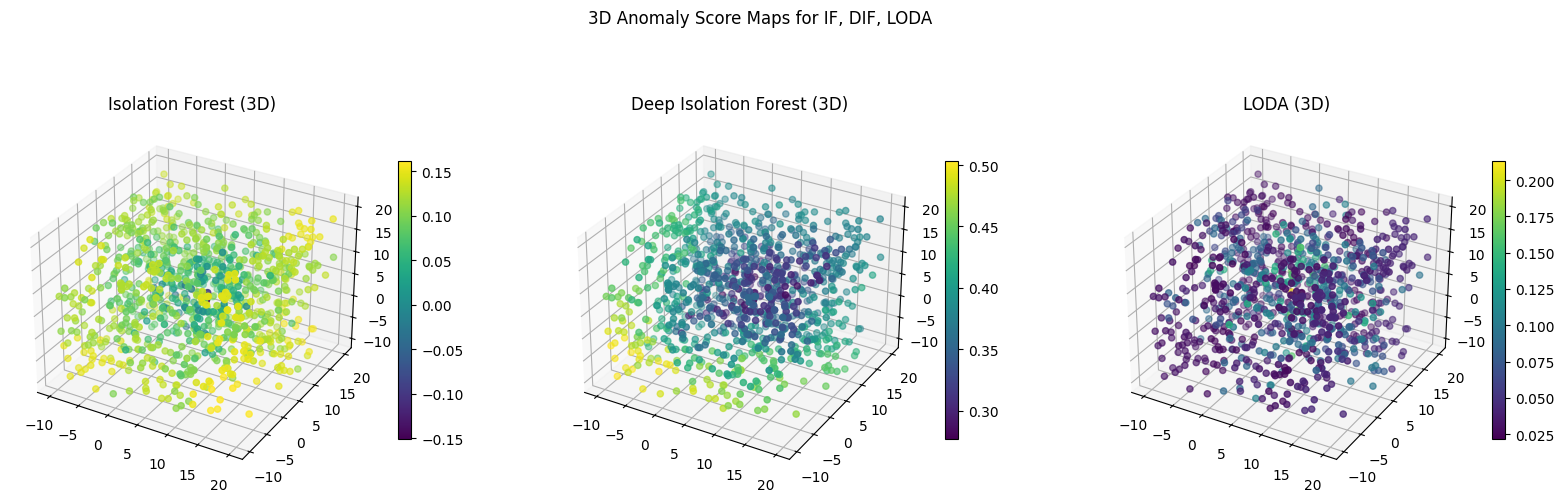

In [ ]:
n_samples = 500
cluster_centers_3d = [(0, 10, 0), (10, 0, 10)]

X2_6, y2_6 = make_blobs(n_samples=[n_samples, n_samples], centers=cluster_centers_3d,
                    cluster_std=1.0, random_state=42)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2_6[:, 0], X2_6[:, 1], X2_6[:, 2], c=y2_6, cmap='viridis', s=20)
ax.set_title("3D Dataset with Two Clusters")
plt.show()

iforest_3d = IForest(contamination=contamination_rate, random_state=42)
dif_3d = DIF(contamination=contamination_rate, random_state=42)
loda_3d = LODA(contamination=contamination_rate)

iforest_3d.fit(X2_6)
dif_3d.fit(X2_6)
loda_3d.fit(X2_6)

test_data_3d = np.random.uniform(-10, 20, (1000, 3))

if_scores_3d = iforest_3d.decision_function(test_data_3d)
dif_scores_3d = dif_3d.decision_function(test_data_3d)
loda_scores_3d = loda_3d.decision_function(test_data_3d)

fig = plt.figure(figsize=(20, 6))

ax1 = fig.add_subplot(131, projection='3d')
p1 = ax1.scatter(test_data_3d[:, 0], test_data_3d[:, 1], test_data_3d[:, 2],
                 c=if_scores_3d, cmap='viridis', s=20)
ax1.set_title("Isolation Forest (3D)")
fig.colorbar(p1, ax=ax1, shrink=0.6)

ax2 = fig.add_subplot(132, projection='3d')
p2 = ax2.scatter(test_data_3d[:, 0], test_data_3d[:, 1], test_data_3d[:, 2],
                 c=dif_scores_3d, cmap='viridis', s=20)
ax2.set_title("Deep Isolation Forest (3D)")
fig.colorbar(p2, ax=ax2, shrink=0.6)

ax3 = fig.add_subplot(133, projection='3d')
p3 = ax3.scatter(test_data_3d[:, 0], test_data_3d[:, 1], test_data_3d[:, 2],
                 c=loda_scores_3d, cmap='viridis', s=20)
ax3.set_title("LODA (3D)")
fig.colorbar(p3, ax=ax3, shrink=0.6)

plt.suptitle("3D Anomaly Score Maps for IF, DIF, LODA")
plt.show()

## Ex3

In [32]:
data = loadmat('shuttle.mat')
X = data['X']
y = data['y'].ravel()

In [33]:
iforest_BA, iforest_ROC = [], []
loda_BA, loda_ROC = [], []
dif_BA, dif_ROC = [], []

n_runs = 10

for _ in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.5, stratify=y, random_state=42
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=42
    )

    scaler = MinMaxScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)

    contamination_rate = np.mean(y_train)

    iforest = IForest(contamination=contamination_rate, random_state=42)
    iforest.fit(X_train_norm)

    iforest_pred = iforest.predict(X_test_norm)
    iforest_scores = iforest.decision_function(X_test_norm)

    iforest_BA.append(balanced_accuracy_score(y_test, iforest_pred))
    iforest_ROC.append(roc_auc_score(y_test, iforest_scores))

    loda = LODA(contamination=contamination_rate)
    loda.fit(X_train_norm)

    loda_pred = loda.predict(X_test_norm)
    loda_scores = loda.decision_function(X_test_norm)

    loda_BA.append(balanced_accuracy_score(y_test, loda_pred))
    loda_ROC.append(roc_auc_score(y_test, loda_scores))

    dif = DIF(contamination=contamination_rate, random_state=42)
    dif.fit(X_train_norm)

    dif_pred = dif.predict(X_test_norm)
    dif_scores = dif.decision_function(X_test_norm)

    dif_BA.append(balanced_accuracy_score(y_test, dif_pred))
    dif_ROC.append(roc_auc_score(y_test, dif_scores))

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warn

In [35]:
print("Isolation Forest")
print("Mean Balanced Accuracy:", np.mean(iforest_BA))
print("Mean ROC AUC:", np.mean(iforest_ROC))
print()

print("LODA")
print("Mean Balanced Accuracy:", np.mean(loda_BA))
print("Mean ROC AUC:", np.mean(loda_ROC))
print()

print("Deep Isolation Forest")
print("Mean Balanced Accuracy:", np.mean(dif_BA))
print("Mean ROC AUC:", np.mean(dif_ROC))

Isolation Forest
Mean Balanced Accuracy: 0.9815898326454949
Mean ROC AUC: 0.9965033899774782

LODA
Mean Balanced Accuracy: 0.6111668100151786
Mean ROC AUC: 0.35052574140865894

Deep Isolation Forest
Mean Balanced Accuracy: 0.7622297568074919
Mean ROC AUC: 0.9598130063581116
